In [71]:
#plotting, load following
source("VDJ_ploting_suite.R")
suppressMessages(require(ggplot2))
suppressMessages(require(gplots))
suppressMessages(require(Seurat))

In [1]:
#testing cell loading, load following
suppressMessages(require(Rtsne))
suppressMessages(require(cellrangerRkit))
suppressMessages(require(data.table))
suppressMessages(require(matrixStats))
require(RUVnormalize)

Loading required package: RUVnormalize


In [2]:
venn_matrix=function(inlist){
    #mk matrix
    out_matrix=matrix(NA,length(inlist),length(inlist))
    colnames(out_matrix)=names(inlist)
    rownames(out_matrix)=names(inlist)
    for(i in 2:length(inlist)){
        for(j in 1:(i-1)){
            out_matrix[i,j]=length(intersect(inlist[[i]],inlist[[j]]))
        }
    }
    diag(out_matrix)=sapply(inlist,length)
    return(out_matrix)
}

center_by_batch=function(inMatrix){
    inMatrix=scale(inMatrix,scale = F)
    batch_ids=as.numeric(stringi::stri_sub(rownames(inMatrix),-1, -1))
    unique_batch_ids=unique(batch_ids)
    for(i in 1:length(unique_batch_ids)){
        tagrow=batch_ids == unique_batch_ids[i]
        inMatrix[tagrow,]=scale(inMatrix[tagrow,],scale = F)
    }
    return(inMatrix)
}

cross_combining=function(string1,string2){
    o=rep("",length(string1)*length(string2))
    k=0
    for(i in 1:length(string1)){
        for(j in 1:length(string2)){
            k=k+1
            o[k]=paste0(string1[i],"_",string2[j])
        } 
    }
    return(o)
}

second_to_humanReadableTime=function(t){
  #change second to a vector of hour,min,second
  h=floor(t/3600)
  t=t-h*3600
  m=floor(t/60)
  t=t-m*60
  s=t
  t=c(h,m,s)
  return(t)
}


In [3]:
genome="GRCh38"
tag_dir="/home/ahe/Analysis/201801_JohnVDJ/data"
sample_list=c(cross_combining(c("C9","C12","U34"),c("pBMC","R")),
              cross_combining(c("C17","C18","C19","C21","C22","C23","C30","C33"),c("pBMC","R","I")))
num_of_unknown_cell_at_most_per_lirary=500
nGeneThreshold=300
mitoUpperThreshold=0.2

#check all sample presenting
existing10x=list.dirs(paste0(tag_dir,"/10x"),recursive = F,full.names = F)
existing10x=gsub("_10x","",existing10x)
if(any(!sample_list %in% existing10x)){
    stop(paste0(paste0(sample_list[!sample_list %in% existing10x],collapse = ", ")," don't exist"))
}

housekeeping_gene=fread("~/Analysis/genomeFiles/housekeeping_gene_human.txt",data.table=F)
housekeeping_gene=housekeeping_gene[,1]

cell_assignment_gps=c("failed BCR/TCR","B cell","T cell","dual-label","unknown")

#sample_list=c(cross_combining(c("C9","C12","U34"),c("pBMC","R")),
              #cross_combining(c("C17","C18","C19"),c("pBMC","R","I")))

mart <- biomaRt::useMart(biomart = "ENSEMBL_MART_ENSEMBL",
  dataset = "hsapiens_gene_ensembl",  #human
  host = 'ensembl.org')
#biomaRt::listAttributes(mart)
t2g <- biomaRt::getBM(attributes = c("ensembl_transcript_id", "ensembl_gene_id",
    "external_gene_name","chromosome_name","start_position","end_position","strand"), mart = mart)
t2g <- dplyr::rename(t2g, target_id = ensembl_transcript_id,
  ens_gene = ensembl_gene_id, ext_gene = external_gene_name)


In [4]:
MTlist=t2g$ens_gene[grep("MT-",t2g$ext_gene)]
IGlist=t2g$ens_gene[grep("IGH|IGK|IGL.*-",t2g$ext_gene)]

SC_matrix=list()
ercc_matrix=list()
cell_assignment=list()
sample_gp=c()
BCR_annoation_list=list()
TCR_annoation_list=list()
BCR_annoation_list_weak=list()
TCR_annoation_list_weak=list()

for(i in 1:length(sample_list)){
    #check file exist (file.exists(destfile))
    SC2read=paste0(tag_dir,"/10x/",sample_list[i],"_10x")
    BCR2read=paste0(tag_dir,"/VDJ/",sample_list[i],"_BCR/outs/all_contig_annotations.csv")
    TCR2read=paste0(tag_dir,"/VDJ/",sample_list[i],"_TCR/outs/all_contig_annotations.csv")
    #read sc
    if(file.exists(BCR2read) | file.exists(TCR2read)){
        valid_cell_barcodes=load_cellranger_matrix_h5(SC2read, genome=genome,barcode_filtered =T)
        valid_cell_barcodes=valid_cell_barcodes$barcode
        SC_matrix[[i]]=load_cellranger_matrix_h5(SC2read, genome=genome,barcode_filtered =F)
        SC_matrix[[i]]=exprs(SC_matrix[[i]])
    }else{
        SC_matrix[[i]]=load_cellranger_matrix_h5(SC2read, genome=genome,barcode_filtered =T)
        valid_cell_barcodes=SC_matrix[[i]]$barcode
        SC_matrix[[i]]=exprs(SC_matrix[[i]])
    }
    
    #if BCR exist, read it
    if(file.exists(BCR2read)){
        BCR_annoation_list[[i]]=fread(BCR2read,sep=",",data.table=F,na.strings = "None")
        #filter the error signal
        BCR_annoation_list[[i]]=BCR_annoation_list[[i]][-grep("TR",BCR_annoation_list[[i]]$chain),]
        #continue BCR TCR processing
        valid_BCR_list=which(BCR_annoation_list[[i]]$is_cell & BCR_annoation_list[[i]]$high_confidence & BCR_annoation_list[[i]]$productive)
        valid_B_list=unique(BCR_annoation_list[[i]]$barcode[valid_BCR_list])
        tag_B=BCR_annoation_list[[i]]$barcode %in% valid_B_list
        BCR_annoation_list_weak[[i]]=BCR_annoation_list[[i]][!tag_B,]
        BCR_annoation_list_weak[[i]]=BCR_annoation_list_weak[[i]][BCR_annoation_list_weak[[i]]$is_cell & BCR_annoation_list_weak[[i]]$high_confidence,]
        BCR_annoation_list[[i]]=BCR_annoation_list[[i]][tag_B,]
        valid_cell_barcodes=unique(c(valid_cell_barcodes,valid_B_list))
    }
    #if TCR exist, read it
    if(file.exists(TCR2read)){
        TCR_annoation_list[[i]]=fread(TCR2read,sep=",",data.table=F,na.strings = "None")   
        #filter the error signal
        TCR_annoation_list[[i]]=TCR_annoation_list[[i]][-grep("IG",TCR_annoation_list[[i]]$chain),]
        #continue BCR TCR processing 
        valid_TCR_list=which(TCR_annoation_list[[i]]$is_cell & TCR_annoation_list[[i]]$high_confidence & TCR_annoation_list[[i]]$productive) 
        valid_T_list=unique(TCR_annoation_list[[i]]$barcode[valid_TCR_list])
        tag_T=TCR_annoation_list[[i]]$barcode %in% valid_T_list
        TCR_annoation_list_weak[[i]]=TCR_annoation_list[[i]][!tag_T,]
        TCR_annoation_list_weak[[i]]=TCR_annoation_list_weak[[i]][TCR_annoation_list_weak[[i]]$is_cell & TCR_annoation_list_weak[[i]]$high_confidence,]
        TCR_annoation_list[[i]]=TCR_annoation_list[[i]][tag_T,]
        valid_cell_barcodes=unique(c(valid_cell_barcodes,valid_T_list))
    }
    
    #the cell selection
    if(file.exists(BCR2read) | file.exists(TCR2read)){
        SC_matrix[[i]]=SC_matrix[[i]][,colnames(SC_matrix[[i]]) %in% valid_cell_barcodes]
    }
    if(file.exists(BCR2read)){
        BCR_annoation_list[[i]]=BCR_annoation_list[[i]][BCR_annoation_list[[i]]$barcode %in% valid_cell_barcodes,]
        BCR_annoation_list[[i]]$barcode=gsub("1$", i, BCR_annoation_list[[i]]$barcode)
        BCR_annoation_list_weak[[i]]$barcode=gsub("1$", i, BCR_annoation_list_weak[[i]]$barcode)  
    }
    if(file.exists(TCR2read)){
        TCR_annoation_list[[i]]=TCR_annoation_list[[i]][TCR_annoation_list[[i]]$barcode %in% valid_cell_barcodes,]
        TCR_annoation_list[[i]]$barcode=gsub("1$", i, TCR_annoation_list[[i]]$barcode)
        TCR_annoation_list_weak[[i]]$barcode=gsub("1$", i, TCR_annoation_list_weak[[i]]$barcode)
    }
    
    #continue SC MATRIX PROCESSION
    SC_matrix[[i]]=t(as.matrix(SC_matrix[[i]]))
    
    #filtering
    enoughGene=rowSums(SC_matrix[[i]]>0)>nGeneThreshold
    SC_matrix[[i]]=SC_matrix[[i]][enoughGene,]
    MTsum=rowSums(SC_matrix[[i]][,colnames(SC_matrix[[i]]) %in% MTlist])
    toomuchmito=MTsum/rowSums(SC_matrix[[i]])>mitoUpperThreshold
    nomito=MTsum==0
    SC_matrix[[i]]=SC_matrix[[i]][(!toomuchmito) & (!nomito),]
    percent_table=t(apply(SC_matrix[[i]],1,function(x){x/sum(x)}))
    percent_table=percent_table[,!colnames(percent_table) %in% IGlist]
    NoDominatingGene=rowSums(percent_table>0.5)==0
    SC_matrix[[i]]=SC_matrix[[i]][NoDominatingGene,]
    
    #renaming
    rownames(SC_matrix[[i]])=gsub("1$", i, rownames(SC_matrix[[i]]))
    
    #cell labeling
    cell_assignment[[i]]=rep("unknown",nrow(SC_matrix[[i]]))    
    if(file.exists(BCR2read) & file.exists(TCR2read)){
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% BCR_annoation_list_weak[[i]]$barcode |
                             rownames(SC_matrix[[i]]) %in% TCR_annoation_list_weak[[i]]$barcode]="failed BCR/TCR"
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% TCR_annoation_list[[i]]$barcode & 
                             rownames(SC_matrix[[i]]) %in% BCR_annoation_list[[i]]$barcode]="dual-label"
    }
    if(file.exists(BCR2read)){
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% BCR_annoation_list_weak[[i]]$barcode]="failed BCR/TCR"
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% BCR_annoation_list[[i]]$barcode]="B cell"
    }
    if(file.exists(TCR2read)){
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% TCR_annoation_list_weak[[i]]$barcode]="failed BCR/TCR"
        cell_assignment[[i]][rownames(SC_matrix[[i]]) %in% TCR_annoation_list[[i]]$barcode]="T cell"
    }
    
    
    #remove the redundant unknown cells
    if(sum(cell_assignment[[i]]=="unknown")>num_of_unknown_cell_at_most_per_lirary){
        tag_unknown=which(cell_assignment[[i]]=="unknown")
        discard_unknown=sample(tag_unknown,length(tag_unknown)-num_of_unknown_cell_at_most_per_lirary,replace = F)
        SC_matrix[[i]]=SC_matrix[[i]][-discard_unknown,]
        cell_assignment[[i]]=cell_assignment[[i]][-discard_unknown]
    }    
    
    sample_gp=c(sample_gp,rep(i,nrow(SC_matrix[[i]])))
    #ercc
    #ercc_matrix[[i]]=load_cellranger_matrix_h5(paste0("/home/ahe/Analysis/201801_JohnVDJ/data/ercc/",sample_list[i],"_10x_ercc"), genome="ercc92",barcode_filtered =F)
    #ercc_matrix[[i]]=exprs(ercc_matrix[[i]])
    #ercc_matrix[[i]]=ercc_matrix[[i]][,match(rownames(SC_matrix[[i]]),colnames(ercc_matrix[[i]]))]
    #ercc_matrix[[i]]=t(as.matrix(ercc_matrix[[i]]))
    #SC_matrix[[i]]=cbind(ercc_matrix[[i]],SC_matrix[[i]])
    t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2)) 
    message(paste0(i,"/",length(sample_list)," loading done: ",t[1],"hr",t[2],"min",round(t[3]),"s"))
    message(paste0("droped by too few gene:",sum(!enoughGene),"| single gene:",sum(!NoDominatingGene),"| mito:",sum(toomuchmito),"|",sum(nomito)))
}

ExpressionMat=do.call(rbind,SC_matrix)
ExpressionMat=ExpressionMat[,colSums(ExpressionMat)>2]
ExpressionBinaryMat=ExpressionMat>=1
ExpressionMat=ExpressionMat[,colSums(ExpressionBinaryMat)>nrow(ExpressionMat)/100]
#ExpressionMat=t(apply(ExpressionMat,1,function(x){x/sum(x)*10000000}))

#change gene name
ExpressionMat=ExpressionMat[,which(colnames(ExpressionMat) %in% t2g$ens_gene)]
colnames(ExpressionMat)=t2g$ext_gene[match(colnames(ExpressionMat),t2g$ens_gene)]
colnames(ExpressionMat)[which(duplicated(colnames(ExpressionMat)))]=paste0(colnames(ExpressionMat)[which(duplicated(colnames(ExpressionMat)))],"_1")

cell_assignment=unlist(cell_assignment)
BCR_annoation=do.call(rbind,BCR_annoation_list)
TCR_annoation=do.call(rbind,TCR_annoation_list)
BCR_annoation_w=do.call(rbind,BCR_annoation_list_weak)
TCR_annoation_w=do.call(rbind,TCR_annoation_list_weak)
rm(SC_matrix,BCR_annoation_list,TCR_annoation_list,TCR_annoation_list_weak,BCR_annoation_list_weak)

ERROR: Error in SC_matrix[[i]][!nomito, ]: (subscript) logical subscript too long


## norm

In [ ]:
#find top variant gene / use ERCC as control
sdY <- apply(ExpressionMat[,-grep("ERCC-",colnames(ExpressionMat))], 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix
ExpressionFiltered=ExpressionMat[,c(grep("ERCC-",colnames(ExpressionMat)),ssd[1:3000]+max(grep("ERCC-",colnames(ExpressionMat))))]

In [8]:
#find top variant gene / use mt gene and house keeping gene as control
taggene_mt=t2g$ext_gene[t2g$chromosome_name=="MT"]
tagmat=t(apply(ExpressionMat,1,function(x){x/sum(x)*1000000}))[,colnames(ExpressionMat) %in% housekeeping_gene]
taggene_hk=colnames(tagmat)[order(colSds(tagmat),decreasing = T)[1:30]]
taggene=c(taggene_mt,housekeeping_gene) #
taggene_posi=which(colnames(ExpressionMat) %in% taggene)

Exp_Seurat <- CreateSeuratObject(raw.data = t(ExpressionMat), project = "CL13", min.cells = 5)
Exp_Seurat@meta.data$batch <- sample_gp
Exp_Seurat <- FilterCells(Exp_Seurat, subset.names = "nGene", low.thresholds = 500, high.thresholds = Inf)
Exp_Seurat <- NormalizeData(Exp_Seurat)
Exp_Seurat <- ScaleData(Exp_Seurat, display.progress = F)
Exp_Seurat <- FindVariableGenes(Exp_Seurat, do.plot = F)
HVG <- head(rownames(Exp_Seurat@hvg.info), 5000)

#TPM + RUV scale
#ExpressionNormed=t(apply(ExpressionFiltered,1,function(x){x/sum(x)*1000000}))
ExpressionNormed=scale(ExpressionMat,scale=F)
ExpressionNormed=naiveRandRUV(ExpressionNormed, which(colnames(ExpressionNormed) %in% taggene), nu.coeff=1e-3, k=10)
ExpressionNormed=scale(ExpressionNormed) #[,-which(colnames(ExpressionNormed) %in% taggene)])

t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
message(paste("Normed done: time consumed:",t[1],"hr",t[2],"min",t[3],"s"))

In [3]:
load("loading_intermediates.Rdata")

### pick one of the norm method

In [19]:
#TPMscale
ExpressionNormed=t(apply(ExpressionFiltered,1,function(x){x/sum(x)*10000000}))
ExpressionNormed=scale(ExpressionNormed)

In [9]:
#RUVscale
ExpressionNormed=scale(ExpressionFiltered,scale=F)
ExpressionNormed=naiveRandRUV(ExpressionNormed, which(colnames(ExpressionNormed) %in% taggene), nu.coeff=1e-3, k=10)
ExpressionNormed=scale(ExpressionNormed) #[,-which(colnames(ExpressionNormed) %in% taggene)]

In [54]:
#TPM + RUV scale
ExpressionNormed=t(apply(ExpressionFiltered,1,function(x){x/sum(x)*1000000}))
ExpressionNormed=scale(ExpressionNormed,scale=F)
ExpressionNormed=naiveRandRUV(ExpressionNormed, which(colnames(ExpressionNormed) %in% taggene), nu.coeff=1e-3, k=10)
ExpressionNormed=scale(ExpressionNormed) #[,-which(colnames(ExpressionNormed) %in% taggene)])

In [25]:
#RUV/TPM scale
TPM_tag=which(rowSums(ExpressionMat[,-grep("ERCC",colnames(ExpressionMat))])<=600)
ExpressionNormed=ExpressionFiltered
tagUMI_for_TPM=max(rowSums(ExpressionNormed[TPM_tag,-grep("ERCC",colnames(ExpressionMat))]))
ExpressionNormed[TPM_tag,]=t(apply(ExpressionFiltered[TPM_tag,],1,function(x){x/sum(x)*tagUMI_for_TPM}))
ExpressionNormed=scale(ExpressionNormed,scale=F)
ExpressionNormed[-TPM_tag,]=naiveRandRUV(ExpressionNormed[-TPM_tag,], grep("ERCC",colnames(ExpressionNormed)), nu.coeff=1e-3, k=20)
ExpressionNormed=scale(ExpressionNormed[,-grep("ERCC",colnames(ExpressionNormed))])

#remove the extra-ordinary large samples
cell_assignment=cell_assignment[-order(rowSums(ExpressionNormed),decreasing = T)[1:ceiling(nrow(ExpressionNormed)/200)]]
ExpressionNormed=ExpressionNormed[-order(rowSums(ExpressionNormed),decreasing = T)[1:ceiling(nrow(ExpressionNormed)/200)],]

Warning message in naiveRandRUV(ExpressionMat_centered, grep("ERCC", colnames(ExpressionMat)), :
“k larger than the rank of Y[, cIdx]. Using k=32 instead”

### TSNE

In [10]:
ptm <- proc.time()
pca_allcell=prcomp(ExpressionNormed)
t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
message (paste("time consumed:",t[1],"hr",t[2],"min",t[3],"s"))
rtsne_allcell=Rtsne(pca_allcell$x[,1:min(25,ncol(pca_allcell$x))],dims=2,max_iter = 1500, pca=F)
t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
message (paste("time consumed:",t[1],"hr",t[2],"min",t[3],"s"))
#save(list=ls(),file="testing_RUVscale_mt_unknownRMed.Rdata")

time consumed: 0 hr 8 min 51.03 s
time consumed: 0 hr 12 min 18.34 s


In [56]:
ls()

[1] "BCR_annoation"                         
 [2] "BCR_annoation_w"                       
 [3] "cell_assignment"                       
 [4] "cell_assignment_gps"                   
 [5] "center_by_batch"                       
 [6] "cross_combining"                       
 [7] "ercc_matrix"                           
 [8] "ExpressionBinaryMat"                   
 [9] "ExpressionFiltered"                    
[10] "ExpressionMat"                         
[11] "ExpressionNormed"                      
[12] "genome"                                
[13] "housekeeping_gene"                     
[14] "i"                                     
[15] "mart"                                  
[16] "num_of_unknown_cell_at_most_per_lirary"
[17] "pca_allcell"                           
[18] "ptm"                                   
[19] "rtsne_allcell"                         
[20] "sample_gp"                             
[21] "sample_list"                           
[22] "sdY"                                   
[23] "second_to_humanReadableTime"           
[24] "ssd"                                   
[25] "t"                                     
[26] "t2g"                                   
[27] "tag_B"                                 
[28] "taggene"                               
[29] "taggene_mt"                            
[30] "taggene_posi"                          
[31] "tag_T"                                 
[32] "TCR_annoation"                         
[33] "TCR_annoation_w"                       
[34] "valid_BCR_list"                        
[35] "valid_B_list"                          
[36] "valid_cell_barcodes"                   
[37] "valid_sc_barcode"                      
[38] "valid_TCR_list"                        
[39] "valid_T_list"                          
[40] "venn_matrix"

In [18]:
ptm <- proc.time()
rtsne_allcell=Rtsne(ExpressionNormed,dims=2,max_iter = 1500)
t=second_to_humanReadableTime(round((proc.time() - ptm)[3],2))
message (paste("time consumed:",t[1],"hr",t[2],"min",t[3],"s"))

## Magic

In [3]:
#load("testing_RUVscale_mt_unknownRMed.Rdata") #testing_TPMscale.Rdata testing_RUVscale_mthk.Rdata
load("180521_RUVscale_800.Rdata")
ls()

In [3]:
suppressMessages(require(feather))

#MAGIC
forMagic="For_magic.feather"
afterMagic="Magic_out.feather"

temp_Exp=as.data.frame(ExpressionNormed)
#magic
write_feather(temp_Exp, forMagic)
system(paste0("python /home/ahe/tools/Lightbulb/src/Lightbulb_MagicWrapper.py --matx ",forMagic," --out ",afterMagic))
ExpressionMat_magic = data.matrix(read_feather(afterMagic))
colnames(ExpressionMat_magic)=gsub("MAGIC ", "", colnames(ExpressionMat_magic))


In [4]:
save(ExpressionMat_magic,sample_list,ExpressionNormed,ExpressionMat,pca_allcell,rtsne_allcell,BCR_annoation,cell_assignment,cell_assignment_gps,sample_gp,TCR_annoation,BCR_annoation_w,TCR_annoation_w,patient_type,tissue_type,patient_assignment,t2g,tissue_assignment,taggene_mt,taggene_hk,HVG,file="180521_RUVscale_800.Rdata")

In [13]:
library(pryr)
mem_used()


Attaching package: ‘pryr’

The following object is masked from ‘package:data.table’:

    address



16.1 GB

# not using

Loading required package: repr


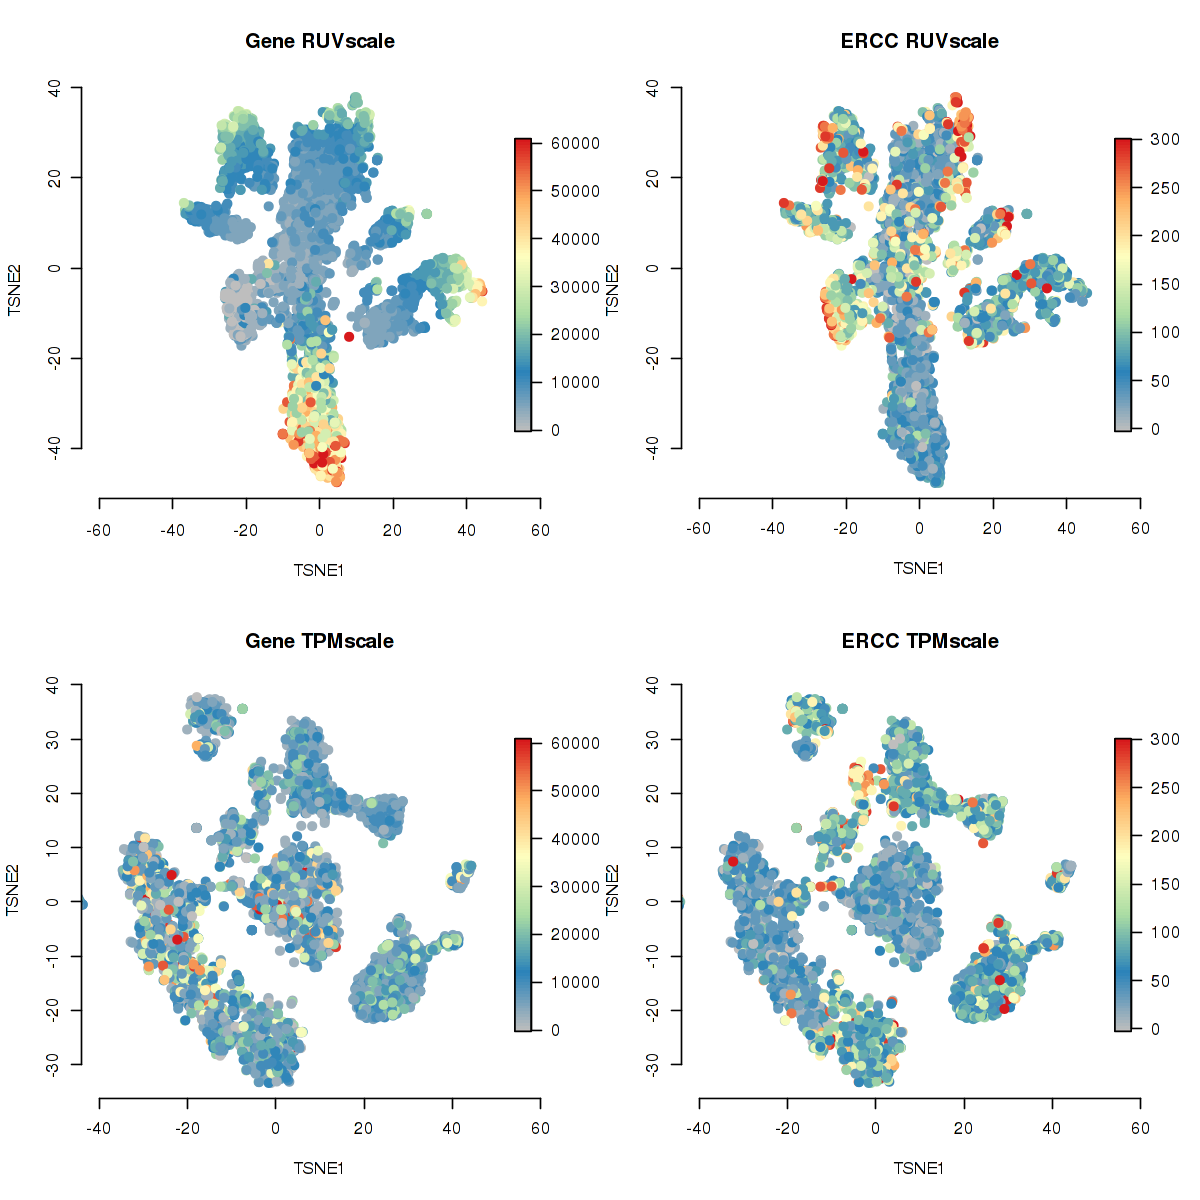

In [7]:
require(repr)
#options(repr.plot.width=10, repr.plot.height=10)
pdf("reads distribution on TSNE plot.pdf",width=10,height=10)
par(mfrow=c(2,2))
rbPal <- colorRampPalette(c('gray','#2b83ba','#abdda4','#ffffbf','#fdae61','#d7191c'))
val=rowSums(ExpressionMat[,-grep("ERCC",colnames(ExpressionMat))])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
Genebreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
Genecols=rbPal(25)[as.numeric(cut(val,breaks = Genebreaks))]

val=rowSums(ExpressionMat[,grep("ERCC",colnames(ExpressionMat))])
lowerbound=sort(val)[round(length(val)/33)]
upperbound=sort(val)[round(length(val)/33*32)]
ERCCbreaks=c(min(val)-1,seq(lowerbound, upperbound, length.out=25),max(val))
ERCCcols=rbPal(25)[as.numeric(cut(val,breaks = ERCCbreaks))]

load("testing_RUVscale.Rdata")
plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene RUVscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

plot(rtsne_allcell$Y,col=ERCCcols,pch=19,xlim=c(-60,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="ERCC RUVscale")
fields::image.plot(legend.only=T,zlim=range(ERCCbreaks), col=rbPal(100))

load("testing_TPMscale.Rdata")
plot(rtsne_allcell$Y,col=Genecols,pch=19,xlim=c(-40,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="Gene TPMscale")
fields::image.plot(legend.only=T,zlim=range(Genebreaks), col=rbPal(100))

plot(rtsne_allcell$Y,col=ERCCcols,pch=19,xlim=c(-40,60),xlab="TSNE1",ylab="TSNE2",bty="n",main="ERCC TPMscale")
fields::image.plot(legend.only=T,zlim=range(ERCCbreaks), col=rbPal(100))
dev.off()

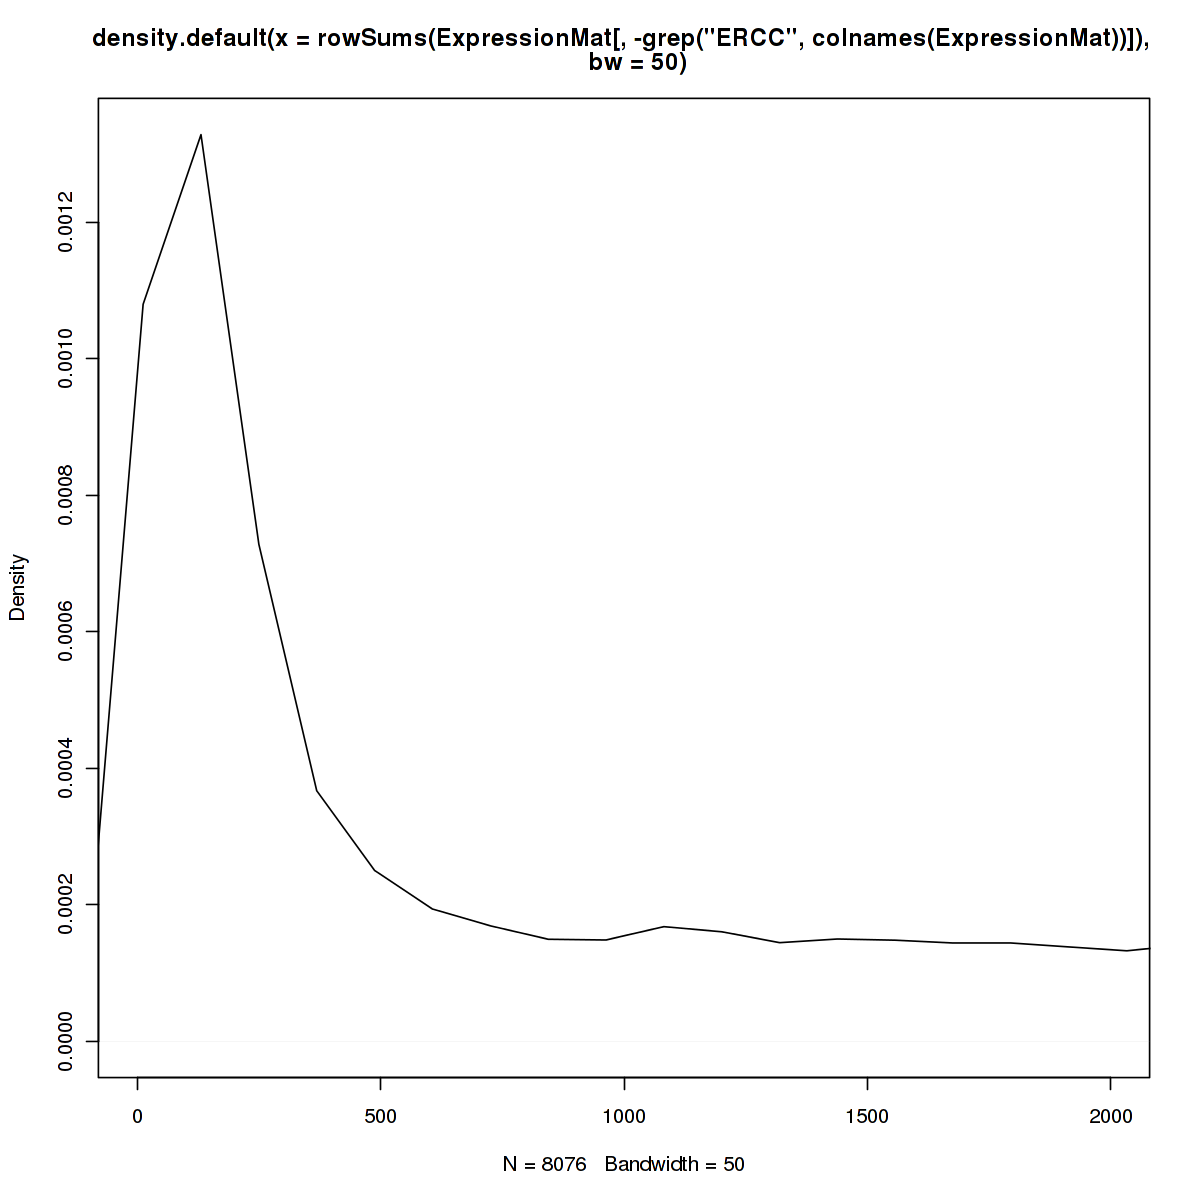

In [23]:
plot(density(rowSums(ExpressionMat[,-grep("ERCC",colnames(ExpressionMat))]),bw=50),xlim=c(0,2000))

# BCR TCR captured only

In [6]:
#using only the BCR/TCR capture cells
ExpressionMat=ExpressionMat[cell_assignment!="unknown",]
sample_gp=sample_gp[cell_assignment!="unknown"]
cell_assignment=cell_assignment[cell_assignment!="unknown"]

In [7]:
rtsne_allcell=Rtsne(ExpressionMat,dims=2,max_iter = 1000)
pca_allcell=prcomp(ExpressionMat)
save(rtsne_allcell,pca_allcell,file="TSNE_PCA_BTCRonly_out.Rdata")
#load("TSNE_PCA_BTCRonly_out.Rdata")

#require(repr)
#options(repr.plot.width=8, repr.plot.height=8)
pdf("TSNE_PCA VDJ captured only scRNAseq.pdf",width=10,height=10)
par(mfcol=c(2,2))

coltouse=cell_assignment
tagcol=RColorBrewer::brewer.pal(length(unique(cell_assignment)),"Set1")
for (i in 1:length(unique(cell_assignment))){
    coltouse[coltouse==unique(cell_assignment)[i]]=tagcol[i]
}
plot(rtsne_allcell$Y,pch=19,col=coltouse,cex=0.5,main="TSNE B/T cell label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+10))
legend("topright",unique(cell_assignment),bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=coltouse,cex=0.5,main="PCA B/T cell label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+10))
legend("topright",unique(cell_assignment),bty = "n",lty=0,pch=19,col=tagcol)

tagcol=RColorBrewer::brewer.pal(length(sample_list),"Set1")
plot(rtsne_allcell$Y,pch=19,col=tagcol[sample_gp],cex=0.5,main="TSNE PBMC/Rectum label",xlim=c(min(rtsne_allcell$Y[,1]),max(rtsne_allcell$Y[,1])+10))
legend("topright",sample_list,bty = "n",lty=0,pch=19,col=tagcol)
plot(pca_allcell$x[,1:2],pch=19,col=tagcol[sample_gp],cex=0.5,main="PCA PBMC/Rectum label",xlim=c(min(pca_allcell$x[,1]),max(pca_allcell$x[,1])+10))
legend("topright",sample_list,bty = "n",lty=0,pch=19,col=tagcol)
dev.off()

png 
  2

# Clonetype Analysis

In [ ]:
#save some BCR and TCR cells
#get all filtered TCR/BCR, see whether their v,d,j,c choice match 

In [31]:
#sample_list=c("C12pBMC","C12Rectum","C9pBMC","C9Rectum")
sample_names=c()
for(i in 1:length(sample_list)){sample_names=c(sample_names,rep(sample_list[i],nrow(TCR_annoation_list[[i]])))}
clonotype_tbl=do.call(rbind,TCR_annoation_list)
clonotype_tbl=cbind(sample_names,clonotype_tbl)


In [32]:
clonotype_tbl[1:5,]

sample_names,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
C12pBMC,AAACGGGCACGGATAG-1,TRUE,AAACGGGCACGGATAG-1_contig_1,TRUE,493,TRB,TRBV15,None,TRBJ2-3,TRBC2,TRUE,True,CATSSQASTQYF,TGTGCCACCAGCTCCCAGGCCAGTACGCAGTATTTT,2230,9,clonotype36,clonotype36_consensus_1
C12pBMC,AAACGGGCACGGATAG-1,TRUE,AAACGGGCACGGATAG-1_contig_2,TRUE,497,TRA,TRAV9-2,None,TRAJ6,TRAC,TRUE,True,CALSDSSGGSYIPTF,TGTGCTCTGAGTGATAGCTCAGGAGGAAGCTACATACCTACATTT,286,1,clonotype36,clonotype36_consensus_2
C12pBMC,AAAGATGTCAGTACGT-1,TRUE,AAAGATGTCAGTACGT-1_contig_1,TRUE,747,TRB,TRBV19,TRBD1,TRBJ1-5,TRBC1,TRUE,True,CASSADRGDQPQHF,TGTGCCAGTAGTGCGGACAGGGGGGATCAGCCCCAGCATTTT,7035,30,clonotype37,clonotype37_consensus_1
C12pBMC,AAAGATGTCAGTACGT-1,TRUE,AAAGATGTCAGTACGT-1_contig_3,TRUE,700,TRA,TRAV1-2,None,TRAJ18,TRAC,TRUE,True,CAVRGRGSTLGRLYF,TGTGCTGTGAGGGGCAGAGGCTCAACCCTGGGGAGGCTATACTTT,1892,9,clonotype37,clonotype37_consensus_2
C12pBMC,AAAGCAATCTACCAGA-1,TRUE,AAAGCAATCTACCAGA-1_contig_1,TRUE,605,TRB,TRBV7-2,TRBD2,TRBJ2-1,TRBC2,TRUE,True,CASTPGTYIYNEQFF,TGTGCCAGCACCCCCGGGACTTATATCTACAATGAGCAGTTCTTC,4252,17,clonotype38,clonotype38_consensus_1


In [5]:
load("testing_tmp.Rdata")

In [13]:
ExpressionMat_centered=scale(ExpressionMat)
nY <- naiveRandRUV(ExpressionMat_centered, grep("ERCC",colnames(ExpressionMat)), nu.coeff=1e-3, k=20)
sdY <- apply(nY[,-grep("ERCC",colnames(ExpressionMat))], 2, sd)
ssd <- sort(sdY,decreasing=TRUE,index.return=TRUE)$ix

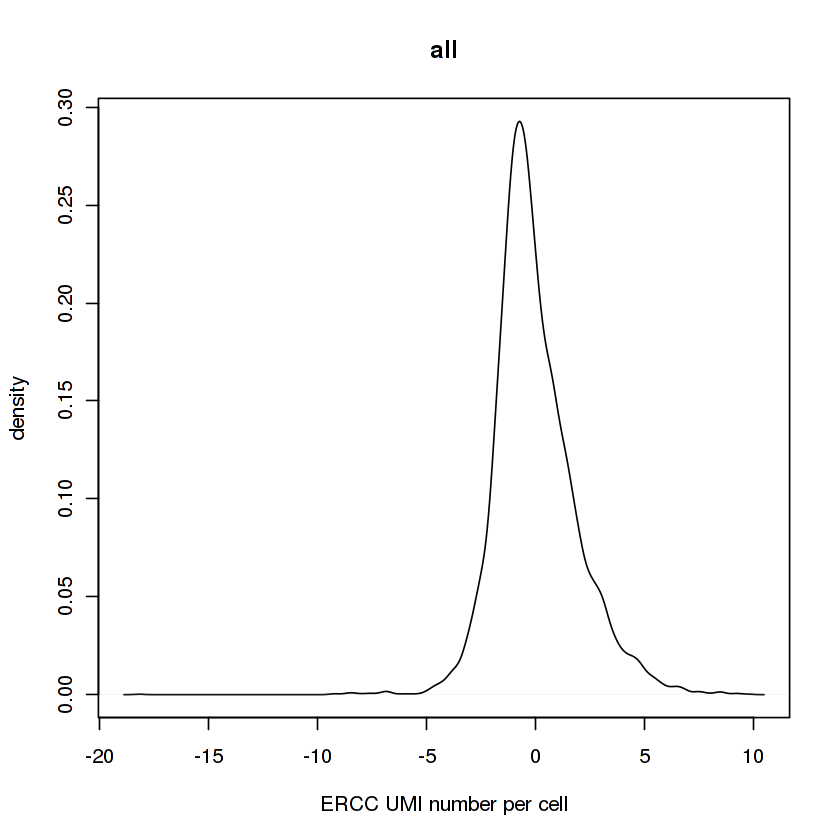

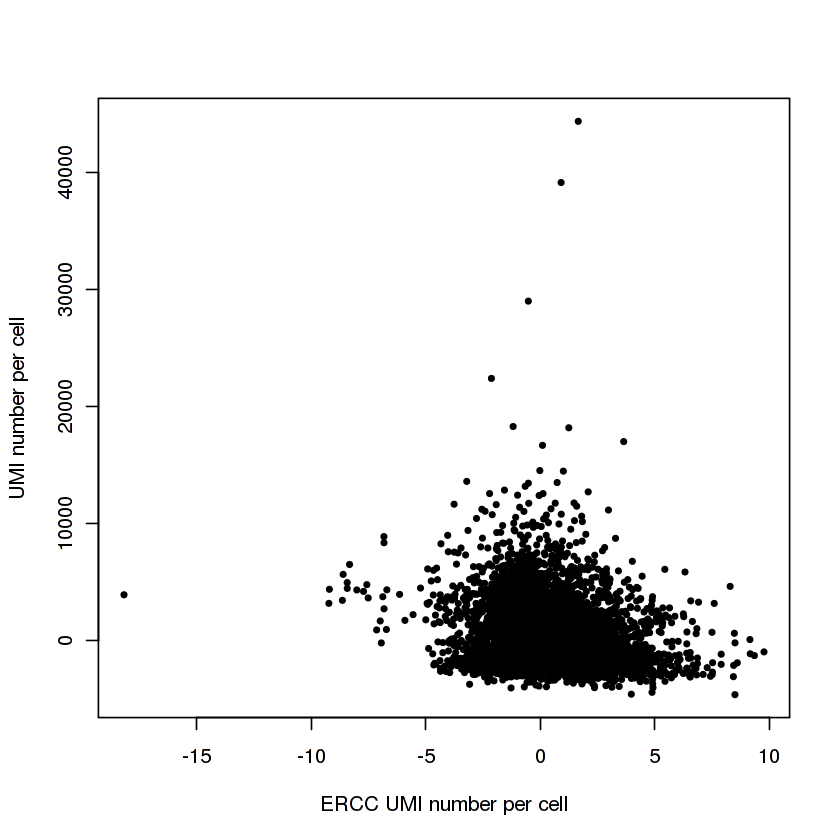

In [14]:
plot(density(rowSums(nY[,grep("ERCC",colnames(nY))])),xlab="ERCC UMI number per cell",ylab="density",main="all")
plot(rowSums(nY[,grep("ERCC",colnames(nY))]),rowSums(nY[,-grep("ERCC",colnames(nY))]),xlab="ERCC UMI number per cell",ylab="UMI number per cell",pch=19,cex=0.5)


In [41]:
which(tmp[which(rowSums(tmp)>1)[1],])

clonotype295_consensus_1                     None 
                     371                      642

In [45]:
TCR_annoation_list[[1]][TCR_annoation_list[[1]]$cdr3_nt=="TGCAGCGTTGAAGACACCGGGGGGGGCTACACCTTC",]

,barcode,is_cell,contig_id,high_confidence,length,chain,v_gene,d_gene,j_gene,c_gene,full_length,productive,cdr3,cdr3_nt,reads,umis,raw_clonotype_id,raw_consensus_id
260,CACATAGCACAGGAGT-1,TRUE,CACATAGCACAGGAGT-1_contig_1,TRUE,591,TRB,TRBV29-1,TRBD1,TRBJ1-2,TRBC1,FALSE,None,CSVEDTGGGYTF,TGCAGCGTTGAAGACACCGGGGGGGGCTACACCTTC,443,2,None,None
833,TCACGAAGTATTCGTG-1,TRUE,TCACGAAGTATTCGTG-1_contig_1,TRUE,533,TRB,TRBV29-1,TRBD1,TRBJ1-2,TRBC1,TRUE,True,CSVEDTGGGYTF,TGCAGCGTTGAAGACACCGGGGGGGGCTACACCTTC,279,2,clonotype295,clonotype295_consensus_1
